# Programming Assignment III: Quantum Arithmetics, QFT & Quantum Walk

## Task 1 — Quantum Arithmetics

### Task 1.1 - Increment and Decrement Operator

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

#### Circle Notation Visualizer

In [2]:
def sv_from_circ(circ: QuantumCircuit) -> np.ndarray:
    """Extract statevector from a quantum circuit."""
    sv = Statevector(circ)
    return np.asarray(sv, dtype=np.complex128)


class QubitSystem:
    def __init__(self, statevector: np.ndarray, label: str = "Qubit System"):
        self.label = label
        self.set_statevector(statevector)

    def set_statevector(self, statevector: np.ndarray):
        sv = np.asarray(statevector, dtype=np.complex128).flatten()
        if sv.ndim != 1:
            raise ValueError("Statevector must be 1D.")
        n_states = sv.size
        n_qubits = int(round(math.log2(n_states)))
        if 2**n_qubits != n_states:
            raise ValueError("Length must be a power of 2.")
        # Defensive normalization (harmless if already normalized)
        norm = np.linalg.norm(sv)
        if norm != 0 and not np.isclose(norm, 1.0):
            sv = sv / norm

        self.n_qubits = n_qubits
        self.n_states = n_states
        self.amps  = sv
        self.prob  = np.abs(sv)**2
        self.phase = np.angle(sv)

    def viz_circle(self, max_cols: int = 8, figsize_scale: float = 2.3):
        cols = max(1, min(max_cols, self.n_states))
        rows = int(math.ceil(self.n_states / cols))

        fig, axes = plt.subplots(
            rows, cols,
            figsize=(cols*figsize_scale, rows*(figsize_scale+0.2))
        )
        axes = np.atleast_2d(axes)

        def bitstr(i: int, n: int) -> str:
            return format(i, f"0{n}b")

        for idx in range(rows * cols):
            r, c = divmod(idx, cols)
            ax = axes[r, c]
            ax.set_aspect("equal")
            ax.set_xlim(0, 1); ax.set_ylim(0, 1)
            ax.axis("off")

            if idx >= self.n_states:
                ax.set_visible(False)
                continue

            # Outer reference circle
            ax.add_patch(plt.Circle((0.5, 0.5), 0.48, fill=False, lw=1.0, alpha=0.5))

            # Filled disk: radius ∝ sqrt(probability) so area ∝ probability
            radius = 0.48 * np.sqrt(self.prob[idx])
            ax.add_patch(plt.Circle((0.5, 0.5), radius, alpha=0.25))

            # Phase arrow
            angle = self.phase[idx]
            L = 0.45
            x2 = 0.5 + L * np.cos(angle)
            y2 = 0.5 + L * np.sin(angle)
            ax.arrow(0.5, 0.5, x2 - 0.5, y2 - 0.5,
                     head_width=0.03, head_length=0.05, length_includes_head=True)

            ax.set_title(f"|{bitstr(idx, self.n_qubits)}⟩", fontsize=10)

        fig.suptitle(self.label, fontsize=12)
        plt.tight_layout()
        plt.show()

#### Quantum Arithmetic Operations

In [3]:
def increment_3qubit(qc: QuantumCircuit):
    """
    Increment a 3-qubit register by 1
    Qubit order: q2 (MSB), q1, q0 (LSB)
    """
    # Increment MSB if needed
    qc.ccx(0, 1, 2)

    # Increment middle bit if needed
    qc.cx(0, 1)

    # Increment LSB
    qc.x(0)


def decrement_3qubit(qc: QuantumCircuit):
    """
    Decrement a 3-qubit register by 1
    Qubit order: q2 (MSB), q1, q0 (LSB)
    """
    # Decrement LSB
    qc.x(0)

    # Decrement middle bit if needed
    qc.cx(0, 1)

    # Decrement MSB if needed
    qc.ccx(0, 1, 2)



#### 1. Prepare a superposition of quantum states using HAD QPU instructions

In [4]:
# Create superposition by applying H gate to the middle qubit
qc = QuantumCircuit(3, name="Initial State")
qc.h(1)


#### 2. Plot the quantum states using the circle notation

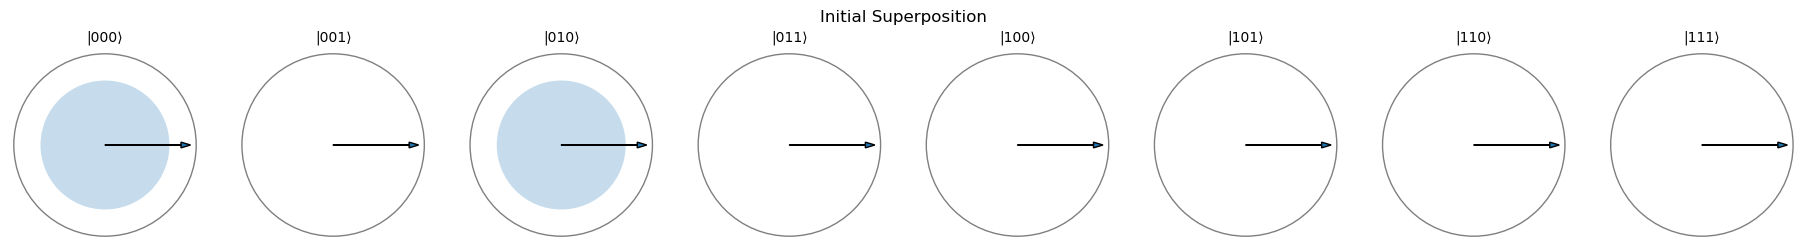

In [5]:
sv = sv_from_circ(qc)
qs = QubitSystem(sv, label="Initial Superposition")
qs.viz_circle()

#### 3. Perform an increment operation

In [6]:
increment_3qubit(qc)

#### 4. Plot the quantum states using the circular notation

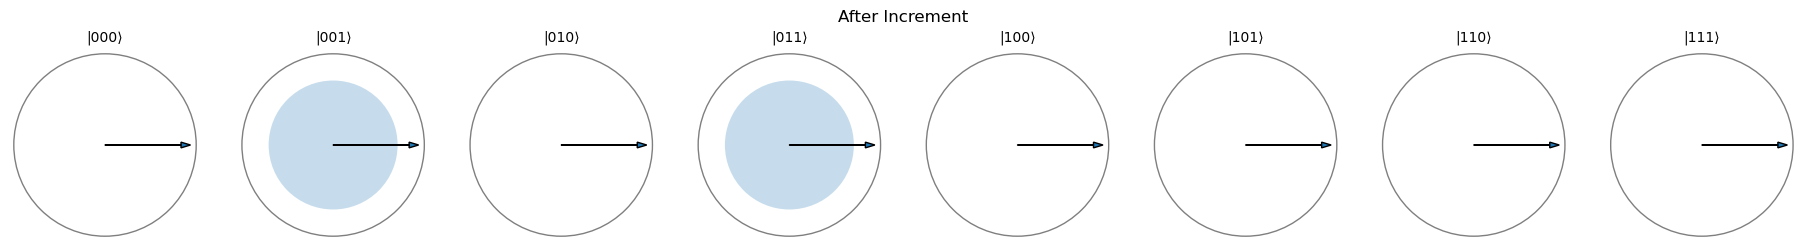

In [7]:
sv = sv_from_circ(qc)
qs = QubitSystem(sv, label="After Increment")
qs.viz_circle()

#### 5. Perform a decrement operation

In [8]:
decrement_3qubit(qc)

#### 6. Plot the quantum states using the circular notation

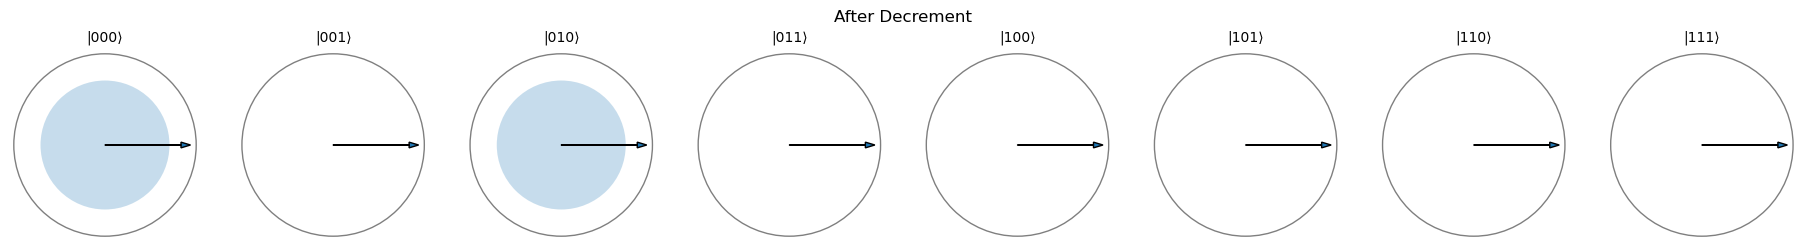

In [9]:
sv = sv_from_circ(qc)
qs = QubitSystem(sv, label="After Decrement")
qs.viz_circle()

### Task 1.2 - Overflow & Underflow / Negative Numbers

#### 1. What happens if we have an overflow (for the increment) or underflow (for the decrement)?

##### Experiment 1: Overflow

Prepare the state |111⟩

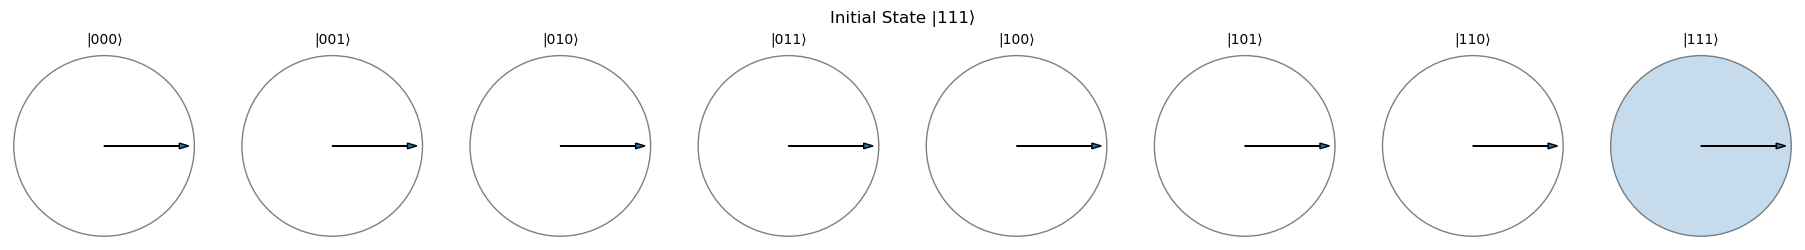

In [10]:
qc = QuantumCircuit(3, name="Initial State |111⟩")
qc.x([0, 1, 2])  # Set all qubits to 1
sv = sv_from_circ(qc)
qs = QubitSystem(sv, label="Initial State |111⟩")
qs.viz_circle()

Perform an increment operation

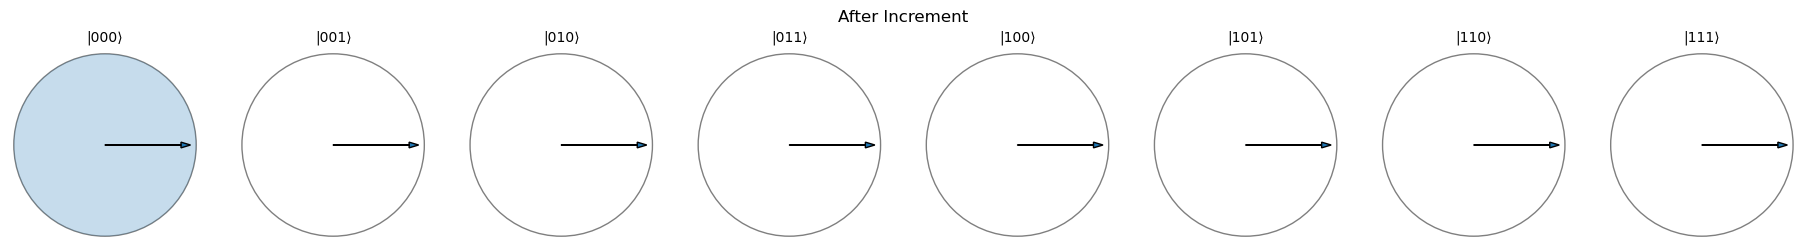

In [11]:
increment_3qubit(qc)
sv = sv_from_circ(qc)
qs = QubitSystem(sv, label="After Increment")
qs.viz_circle()

We can see that incrementing |111⟩ results in |000⟩, demonstrating that when an overflow occurs the state wraps around to the beginning of the range.

##### Experiment 2: Underflow

Prepare the state |000⟩

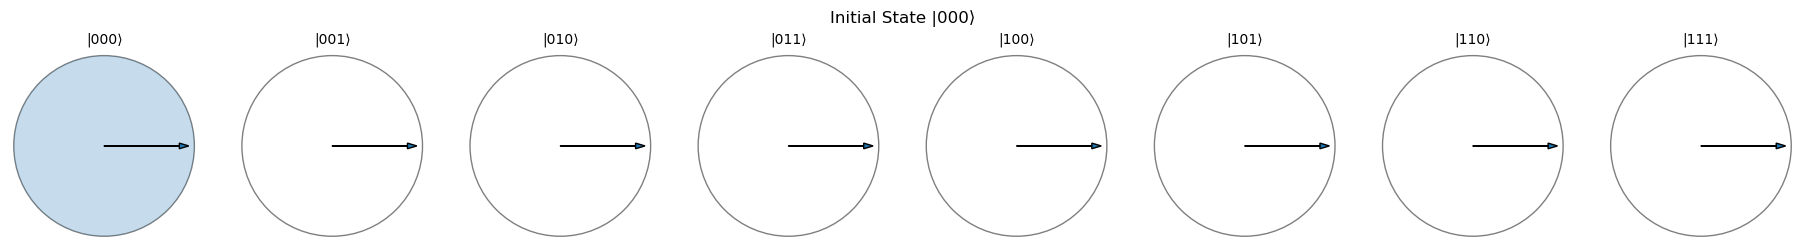

In [12]:
qc = QuantumCircuit(3, name="Initial State |000⟩")
sv = sv_from_circ(qc)
qs = QubitSystem(sv, label="Initial State |000⟩")
qs.viz_circle()

Perform a decrement operation

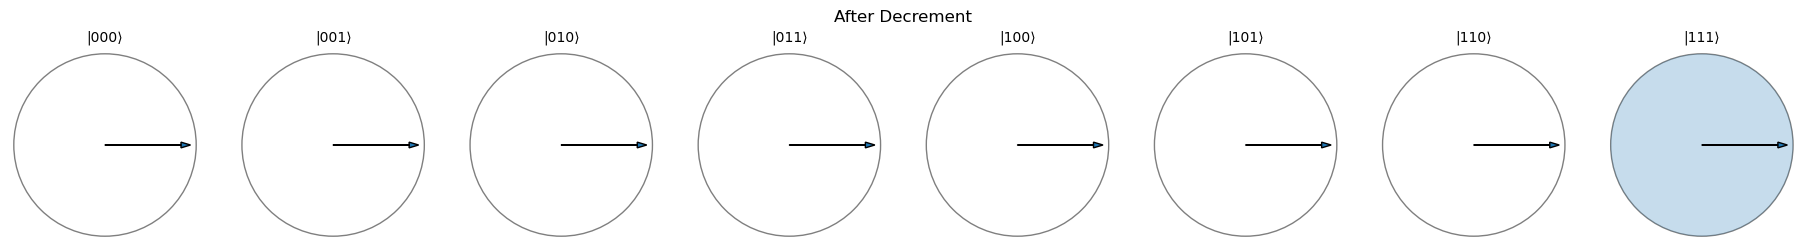

In [13]:
decrement_3qubit(qc)
sv = sv_from_circ(qc)
qs = QubitSystem(sv, label="After Decrement")
qs.viz_circle()

We can see that decrementing |000⟩ results in |111⟩, demonstrating that when an underflow occurs the state wraps around to the maximum value in the range.

#### 2. Do increment and decrement operations also work with negative integer numbers?

**Answer:** Yes, the increment and decrement operations work correctly with negative numbers when interpreted using **two's complement representation**. Importantly, the quantum circuit remains unchanged since only our interpretation of the bit patterns differs.

In a 3-qubit system with two's complement:
- |000⟩ = 0, |001⟩ = 1, |010⟩ = 2, |011⟩ = 3
- |100⟩ = -4, |101⟩ = -3, |110⟩ = -2, |111⟩ = -1

The MSB (q2) acts as the sign bit.

##### Example: -1 + 1 = 0

Prepare the state |111⟩ (which represents -1 in two's complement)

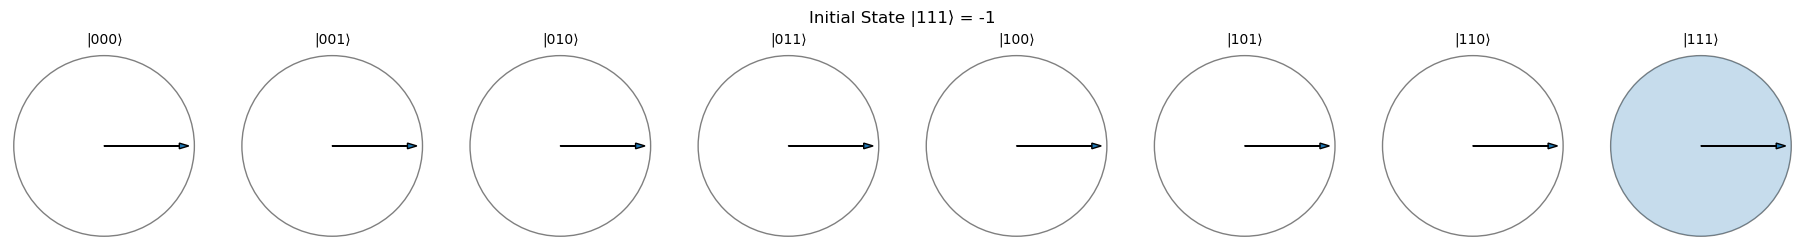

In [14]:
qc = QuantumCircuit(3, name="Two's complement: -1")
qc.x([0, 1, 2])
sv = sv_from_circ(qc)
qs = QubitSystem(sv, label="Initial State |111⟩ = -1")
qs.viz_circle()

Perform increment operation: -1 + 1 should equal 0

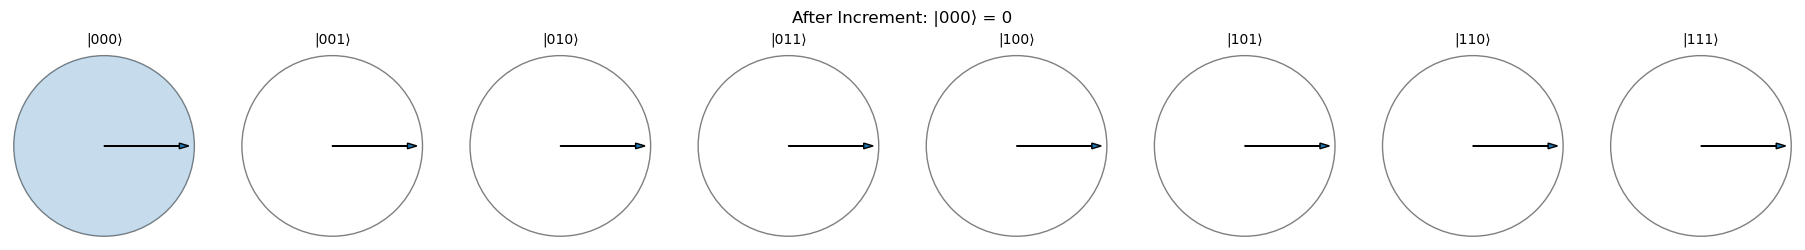

In [15]:
increment_3qubit(qc)
sv = sv_from_circ(qc)
qs = QubitSystem(sv, label="After Increment: |000⟩ = 0")
qs.viz_circle()

##### Example 2: -2 - 1 = -3

Prepare the state |110⟩ (which represents -2 in two's complement)

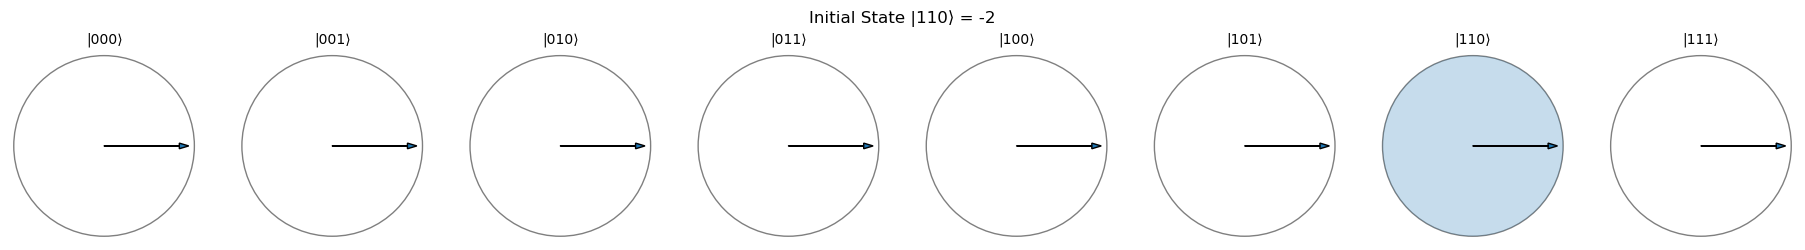

In [16]:
qc = QuantumCircuit(3, name="Two's complement: -2")
qc.x([1, 2])
sv = sv_from_circ(qc)
qs = QubitSystem(sv, label="Initial State |110⟩ = -2")
qs.viz_circle()

Perform decrement operation: -2 - 1 should equal -3

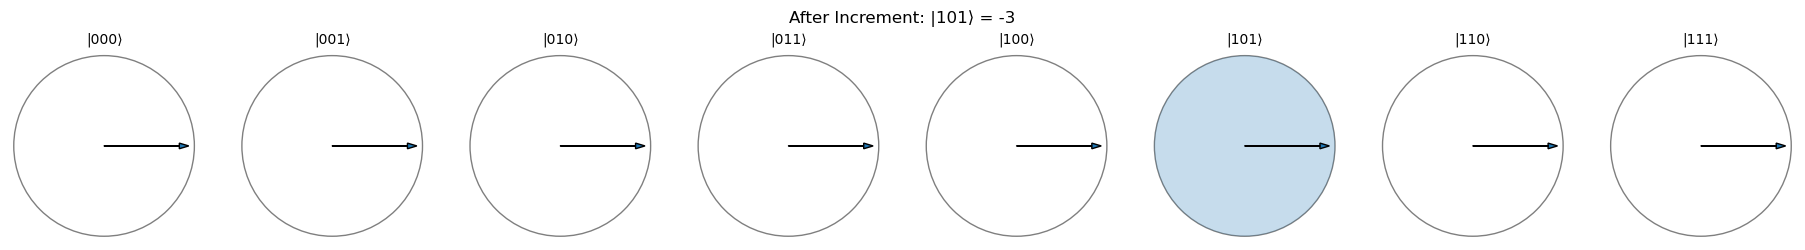

In [17]:
decrement_3qubit(qc)
sv = sv_from_circ(qc)
qs = QubitSystem(sv, label="After Increment: |101⟩ = -3")
qs.viz_circle()

**Conclusion:** The first example shows that the overflow case can be reinterpreted as -1 + 1 = 0 in two's complement. The second example demonstrates decrementing an already negative number (-2 - 1 = -3). Both confirm that the same quantum circuits work for signed arithmetic, as the modular arithmetic (mod 8) naturally implements two's complement behavior.

However, signed overflow still occurs at the boundaries:
- Incrementing |011⟩ (3, max positive) → |100⟩ (-4, min negative)
- Decrementing |100⟩ (-4, min negative) → |011⟩ (3, max positive)

This wraparound behavior is inherent to modular arithmetic and affects both signed and unsigned interpretations.

## Task 2 — Quantum Fourier Transform

### Task 2.1 - QFT and Preparation Circuit

#### QFT Circuit Design Description, including Preparation Circuit:

This implementation constructs a 4-qubit quantum circuit with two main components:

**Preparation Gates (`prep_circuit_4qubit`):**
- Hadamard gates are applied to all 4 qubits (q0-q3) to create an equal superposition of all basis states
- A phase gate P(π) is applied to qubit 1, introducing a 180° phase rotation

**4-Qubit QFT Implementation (`qft_4qubit`):**
The Quantum Fourier Transform is applied in 5 steps:
- **Steps 1-4:** Sequential processing of qubits from q3 down to q0. Each step applies a Hadamard gate followed by controlled-phase (CP) gates with decreasing angles (-π/2, -π/4, -π/8)
- **Step 5:** Qubit reversal using SWAP gates [SWAP(q0, q3) and SWAP(q1, q2)] to reverse the qubit order, which is necessary because the QFT naturally outputs qubits in reversed order

#### Implementation of 4-Qubit QFT

In [18]:
def prep_circuit_4qubit(qc: QuantumCircuit):
    if qc.num_qubits != 4:
        raise ValueError("Quantum circuit must have exactly 4 qubits.")

    qc.barrier(label="Preparation")
    for q in range(4):
        qc.h(q)
    qc.p(np.pi, 1)

def qft_4qubit(qc: QuantumCircuit):
    """
    Implement 4-qubit Quantum Fourier Transform
    """
    # Ensure the circuit has exactly 4 qubits
    if qc.num_qubits != 4:
        raise ValueError("Quantum circuit must have exactly 4 qubits.")

    # QFT implementation
    qc.barrier(label="QFT")
    qc.barrier(label="1st Block")
    qc.h(3)
    qc.cp(-np.pi/2, 2, 3)
    qc.cp(-np.pi/4, 1, 3)
    qc.cp(-np.pi/8, 0, 3)
    qc.barrier(label="2nd Block")
    qc.h(2)
    qc.cp(-np.pi/2, 1, 2)
    qc.cp(-np.pi/4, 0, 2)
    qc.barrier(label="3rd Block")
    qc.h(1)
    qc.cp(-np.pi/2, 0, 1)
    qc.barrier(label="4th Block")
    qc.h(0)
    # Swap qubits to reverse order
    qc.barrier(label="5th Block")
    qc.swap(0, 3)
    qc.swap(1, 2)

#### Build Complete Circuit: Preparation + QFT

In [19]:
# Create quantum circuit with 4 qubits
qc = QuantumCircuit(4, name="Preparation + QFT")

# Preparation
prep_circuit_4qubit(qc)

# Apply QFT
qft_4qubit(qc)

#### Circuit Diagram

In [20]:
qc.draw(output='text', fold=-1)

Preparation ┌───┐         QFT  1st Block                                     2nd Block                           3rd Block                 4th Block ┌───┐ 5th Block       
q_0: ──────░──────┤ H ├──────────░───────░───────────────────────────────■─────────────░─────────────────────■─────────────░───────────■─────────────░─────┤ H ├─────░──────X────
           ░      ├───┤┌──────┐  ░       ░                               │             ░                     │             ░     ┌───┐ │P(-π/2)      ░     └───┘     ░      │    
q_1: ──────░──────┤ H ├┤ P(π) ├──░───────░─────────────────────■─────────┼─────────────░───────────■─────────┼─────────────░─────┤ H ├─■─────────────░───────────────░──────┼──X─
           ░      ├───┤└──────┘  ░       ░                     │         │             ░     ┌───┐ │P(-π/2)  │P(-π/4)      ░     └───┘               ░               ░      │  │ 
q_2: ──────░──────┤ H ├──────────░───────░───────────■─────────┼─────────┼─────────────░─────┤ H ├─■─────────■─────────────░─────────────────────────░───────────────░──────┼──X─
           ░      ├───┤          ░       ░     ┌───┐ │P(-π/2)  │P(-π/4)  │P(-π/8)      ░     └───┘                         ░                         ░               ░      │    
q_3: ──────░──────┤ H ├──────────░───────░─────┤ H ├─■─────────■─────────■─────────────░───────────────────────────────────░─────────────────────────░───────────────░──────X────
           ░      └───┘          ░       ░     └───┘                                   ░                                   ░                         ░               ░

### Task 2.2 - Circle Notation

#### 1. Prepare the input using the preparation circuit (already done above, but repeated here for clarity)

In [21]:
qc = QuantumCircuit(4, name="Preparation + QFT")
prep_circuit_4qubit(qc)

#### 2. Plot the quantum states using the circle notation.

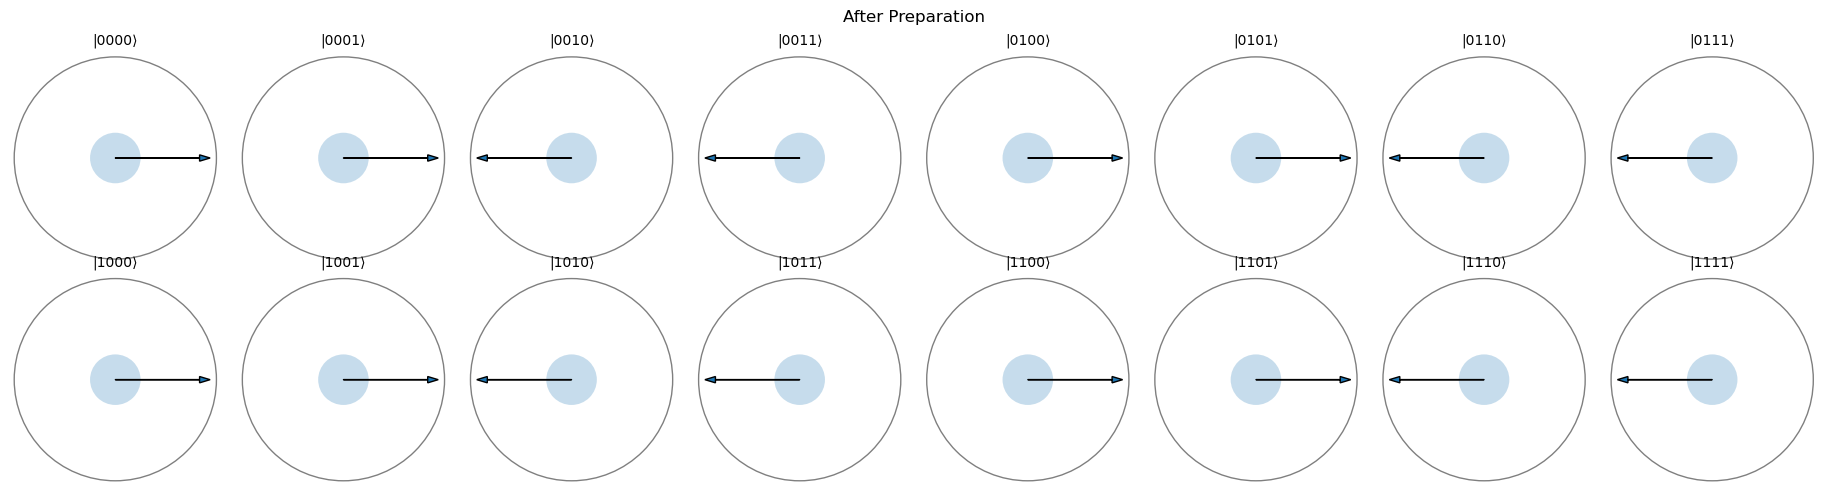

In [22]:
sv = sv_from_circ(qc)
qs = QubitSystem(sv, label="After Preparation")
qs.viz_circle()

1. **Which signal does the preparation circuit prepare?** The preparation circuit prepares a signal with a frequency component at position/bin 1 in the frequency domain, created by applying Hadamard gates to all qubits for superposition and a P(π) phase gate to qubit 1, which the QFT then reveals as a localized frequency peak.

#### 3. Perform the QFT operation (already done above, but repeated here for clarity)

In [23]:
qft_4qubit(qc)

#### 4. Plot the resulting quantum states using the circle notation.

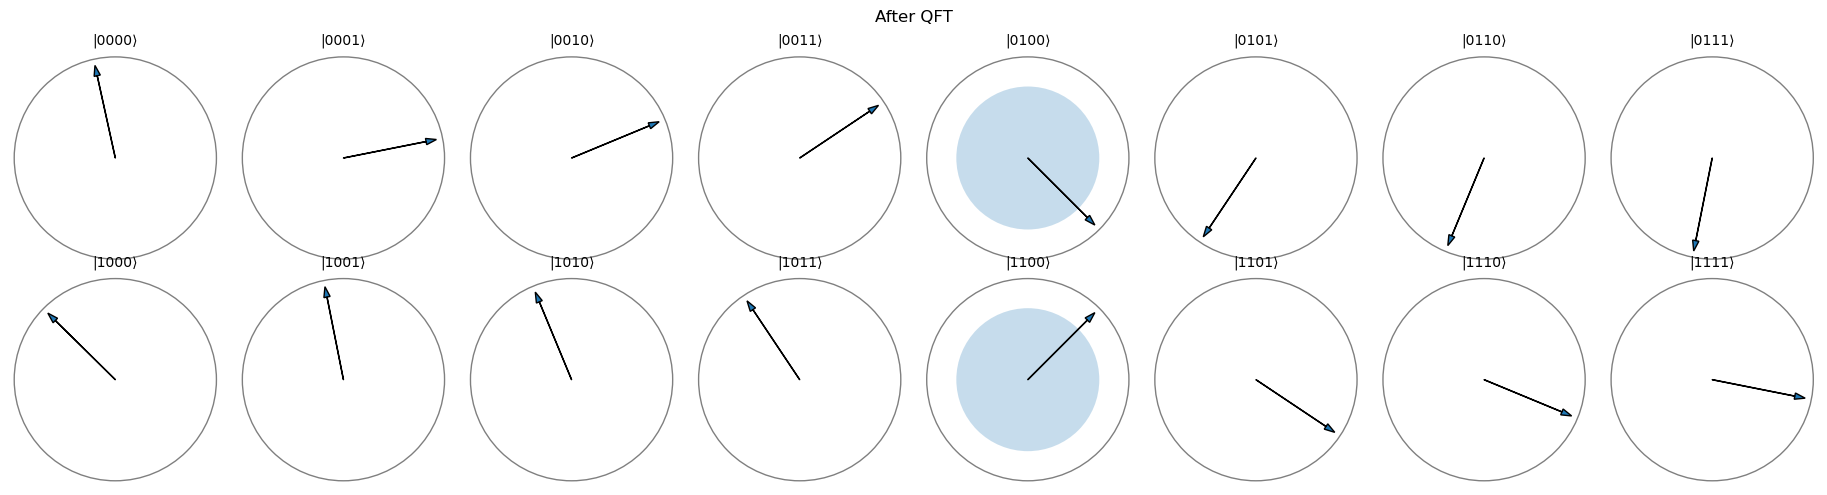

In [24]:
sv = sv_from_circ(qc)
qs = QubitSystem(sv, label="After QFT")
qs.viz_circle()

### Task 2.3 - Discussion

#### Results:
The QFT successfully transformed the input from computational to frequency domain. The preparation circuit created equal superposition with a π phase on qubit 1, encoding frequency content. Post-QFT, probability concentrates at state |1⟩, confirming the frequency component at bin 1.

#### Comparison with Classical DFT/FFT:

##### Similarities:
- Both perform discrete Fourier transform: |k⟩ → (1/√N) Σⱼ e^(2πijk/N) |j⟩
- Extract frequency information from phase-encoded signals
- Reversible transformations
- 4 qubits = 16 frequency bins (equivalent to 16-point DFT)

##### Key Differences:
- Complexity: Classical FFT requires O(N log N) operations vs QFT's O(log² N) gates. For N=16: ~64 operations vs ~20 gates (exponential speedup)
- Data Access: Classical FFT gives direct access to all coefficients; QFT stores data in superposition requiring measurement
- Output Extraction: Classical returns N explicit values; quantum requires multiple runs or phase estimation algorithms
- Practical Trade-off: QFT's gate advantage is offset by state preparation and measurement overhead for classical data

##### When QFT Excels:
- Embedded in quantum algorithms where input is already in superposition (Shor's algorithm, quantum phase estimation)
- When only specific frequency information is needed rather than full spectrum

#### Circle Notation Observations:
- Before QFT: Uniform probabilities across all states, with varying phases encoding the frequency content
- After QFT: Sharp probability peak at |1⟩ with negligible amplitude elsewhere, successfully extracting the frequency component from phase patterns
























## BONUS TASK: Discrete Quantum Walk on a Line

### Task B.1 - Quantum walk implementation

In [25]:
from qiskit import QuantumRegister, ClassicalRegister

def insert_ctrl_increment(qc: QuantumCircuit, walk, coin):
    n = len(walk)
    for i in reversed(range(n)):
        controls = [coin[0]] + [walk[j] for j in range(i)]
        qc.mcx(controls, walk[i])
    
    return

def insert_ctrl_decrement(qc: QuantumCircuit, walk, coin):
    n = len(walk)
    for i in range(n):
        controls = [coin[0]] + [walk[j] for j in range(i)]
        qc.mcx(controls, walk[i])
    
    return

def insert_step_module(qc: QuantumCircuit, walk, coin):

    qc.h(coin[0])
    insert_ctrl_increment(qc, walk, coin)
    qc.x(coin[0])
    insert_ctrl_decrement(qc, walk, coin)
    qc.x(coin[0])
    
    return

def create_walk_circuit(num_walk_qubits: int, start_pos: int, walker_iterations: int):
    walk_space = QuantumRegister(num_walk_qubits, "walk")
    coin = QuantumRegister(1, "coin")
    c = ClassicalRegister(num_walk_qubits, "c")
    
    qc = QuantumCircuit(walk_space, coin, name=f"Quantum Walk Circuit {num_walk_qubits}")
    
    bin_str = format(start_pos, f'0{num_walk_qubits}b')
    # Apply X on qubits where bit == '1'
    for idx, bit in enumerate(reversed(bin_str)):
        if bit == '1':
            qc.x(walk_space[idx])

    for i in range(walker_iterations):
        insert_step_module(qc, walk_space, coin)

    qc.add_register(c)
    qc.measure(walk_space, c)
    return qc

In [26]:
qc = create_walk_circuit(num_walk_qubits=3, start_pos=3, walker_iterations=2)
print(qc)

        ┌───┐          ┌───┐     ┌───┐                              ┌───┐     »
walk_0: ┤ X ├──■────■──┤ X ├─────┤ X ├──■────■──────────────■────■──┤ X ├─────»
        ├───┤  │  ┌─┴─┐└─┬─┘     └─┬─┘┌─┴─┐  │              │  ┌─┴─┐└─┬─┘     »
walk_1: ┤ X ├──■──┤ X ├──┼─────────┼──┤ X ├──■──────────────■──┤ X ├──┼───────»
        └───┘┌─┴─┐└─┬─┘  │         │  └─┬─┘┌─┴─┐          ┌─┴─┐└─┬─┘  │       »
walk_2: ─────┤ X ├──┼────┼─────────┼────┼──┤ X ├──────────┤ X ├──┼────┼───────»
        ┌───┐└─┬─┘  │    │  ┌───┐  │    │  └─┬─┘┌───┐┌───┐└─┬─┘  │    │  ┌───┐»
  coin: ┤ H ├──■────■────■──┤ X ├──■────■────■──┤ X ├┤ H ├──■────■────■──┤ X ├»
        └───┘               └───┘               └───┘└───┘               └───┘»
   c: 3/══════════════════════════════════════════════════════════════════════»
                                                                              »
«        ┌───┐               ┌─┐      
«walk_0: ┤ X ├──■────■───────┤M├──────
«        └─┬─┘┌─┴─┐  │       └╥┘┌─┐   
«wa

The above circuit is the schematic for 2 walker iterations. The 10-walker iteration circuit is not included for clarity reasons. It is similar to this one but has multiple copies of the "step module". The circuit is similar to Task 1 because it uses the same increment and decrement logic, modified by an extra control line. As a result, we could also work with negative walk positions and also have to inadvertly deal with over- and underflow.

### Task B.2

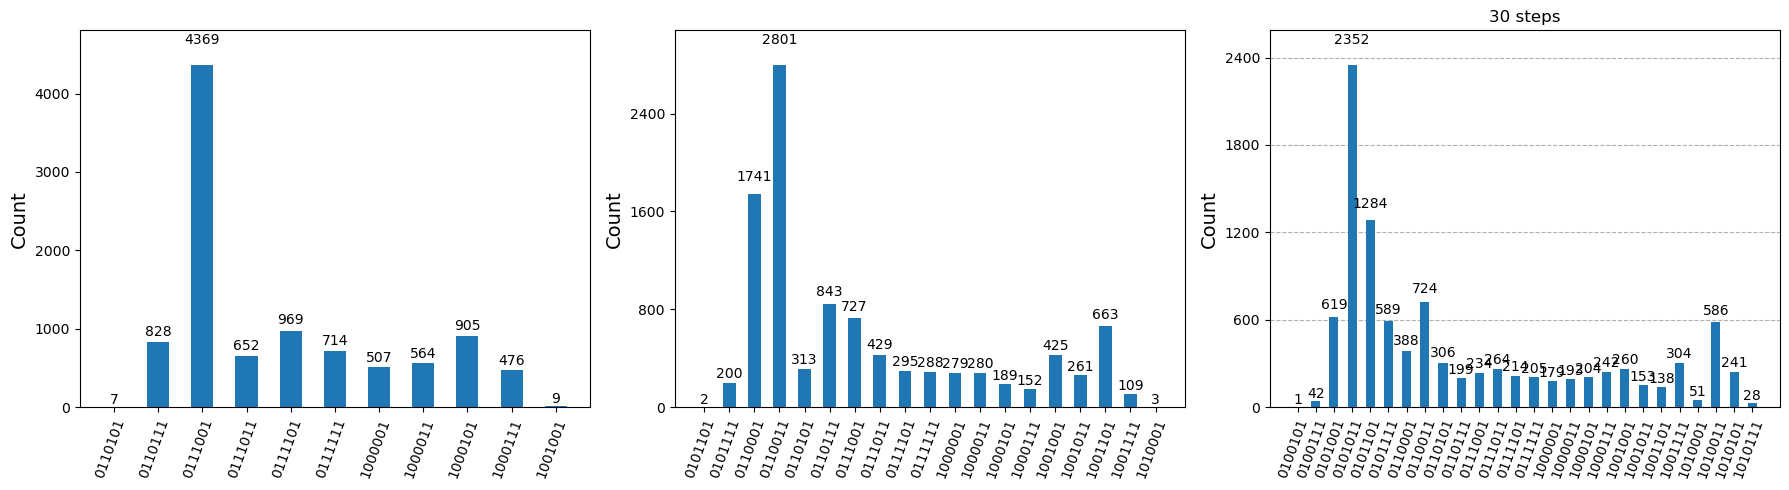

In [27]:
from qiskit_aer import Aer
from qiskit import transpile
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# Use the QASM simulator (samples like a real device)
sim = Aer.get_backend("qasm_simulator")

SHOTS = 10000
steps = [10, 20, 30]
all_counts = {}

for i in steps:
    qc = create_walk_circuit(num_walk_qubits=7, start_pos=63, walker_iterations=i)
    tqc = transpile(qc, sim)
    result = sim.run(tqc, shots=SHOTS).result()
    counts = result.get_counts(qc)

    all_counts[f"{i} steps"] = counts

# Plot 3 histograms side by side
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for ax, (label, counts) in zip(axs, all_counts.items()):
    plot_histogram(counts, ax=ax, title=label)

plt.tight_layout()
plt.show()

A classical random walk will have a symmetric distribution when enough shots are taken. The assymetric distribution is caused by the repeated use of the Hadamard gate to the coin qubit. Over time, interference causes the coin qubit to bias to the left, but also creates a small bump far to the right as well. Amplitudes from different paths can interfere constructively (enhancing probabilities in some positions) or destructively (canceling out probabilities in other positions). This interference is why the quantum walk spreads faster and develops a very different shape compared to the smooth Gaussian of a classical walk. The quantum walk is also much faster to compute than the classical walk.

### Task B.3


In [28]:
import cirq
import random
import numpy as np
from matplotlib import pyplot as plt
import scipy
import scipy.special


In [29]:
number_qubits = 7
qubits = cirq.GridQubit.rect(1, number_qubits)


In [30]:
def initial_state():

    yield cirq.X.on(cirq.GridQubit(0, 1))
    yield cirq.X.on(cirq.GridQubit(0, number_qubits))


In [31]:
def walk_step():

    # "Flip" the coin vector

    yield cirq.H.on(cirq.GridQubit(0, number_qubits))

    # Implement the Addition Operator

    yield cirq.X.on(cirq.GridQubit(0, number_qubits))

    for i in range(number_qubits, 0, -1):

        controls = [cirq.GridQubit(0, v) for v in range(number_qubits, i - 1, -1)]
        yield cirq.X.on(cirq.GridQubit(0, i - 1)).controlled_by(*controls)
        if i > 1:
            yield cirq.X.on(cirq.GridQubit(0, i - 1))

    yield cirq.X.on(cirq.GridQubit(0, number_qubits))

    # Implement the Subtraction Operator

    for i in range(1, number_qubits + 1):

        controls = [cirq.GridQubit(0, v) for v in range(number_qubits, i - 1, -1)]
        yield cirq.X.on(cirq.GridQubit(0, i - 1)).controlled_by(*controls)
        if i < number_qubits:
            yield cirq.X.on(cirq.GridQubit(0, i))


In [32]:
number_qubits = 7
iterator = 30
sample_number = 5000


def generate_walk(number_qubits, iterator, sample_number):

    circuit = cirq.Circuit()

    circuit.append(initial_state())
    for j in range(iterator):
        circuit.append(walk_step())
    circuit.append(cirq.measure(*qubits, key='x'))

    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=sample_number)
    final = result.histogram(key='x')

    return final


final = generate_walk(number_qubits, iterator, sample_number)
print(final)


Counter({12: 1229, 14: 622, 20: 322, 10: 320, 16: 278, 52: 255, 18: 211, 48: 184, 22: 157, 28: 147, 40: 137, 54: 133, 30: 128, 26: 119, 32: 117, 42: 114, 38: 94, 34: 84, 24: 81, 36: 80, 46: 62, 44: 58, 8: 32, 50: 24, 56: 11, 6: 1})


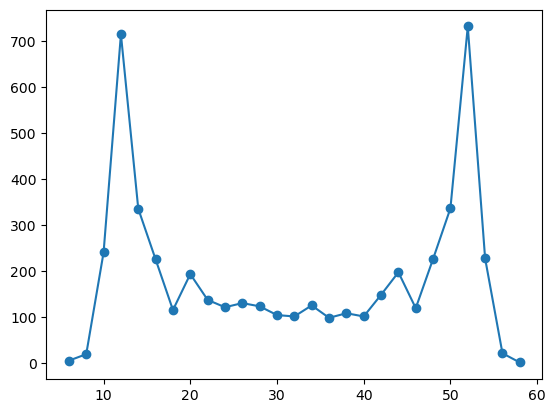

In [33]:
def graph(final):

    x_arr = list(final.keys())
    y_arr = [dict(final)[j] for j in dict(final).keys()]

    x_arr_final = []
    y_arr_final = []

    while len(x_arr) > 0:

        x_arr_final.append(min(x_arr))
        y_arr_final.append(y_arr[x_arr.index(min(x_arr))])
        holder = x_arr.index(min(x_arr))
        del x_arr[holder]
        del y_arr[holder]

    plt.plot(x_arr_final, y_arr_final)
    plt.scatter(x_arr_final, y_arr_final)
    plt.show()

def initial_state():

    yield cirq.X.on(cirq.GridQubit(0, 1))

    yield cirq.H.on(cirq.GridQubit(0, number_qubits))
    yield cirq.S.on(cirq.GridQubit(0, number_qubits))


final = generate_walk(number_qubits, iterator, sample_number)
graph(final)


The superposition of states can be achieved by using a Hadamard gate in sequence with a S-gate (phase). Initiating the walk will then result in a pattern as above. It is now symmetrical because the distribution is not biased anymore to one side. This is noticeable by the graph which resembles the graph of Task B.2 but now contains 2 copies of the initial distribution.

### Task B.4

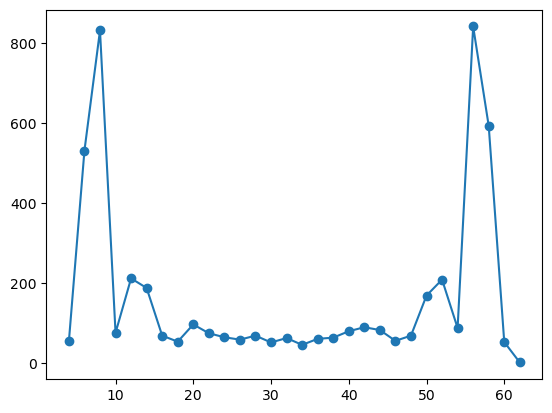

In [34]:
def walk_step():

    # "Flip" the coin vector

    theta = np.pi / 3  # π/2 gives an equal superposition, you can change for bias
    yield cirq.ry(theta).on(cirq.GridQubit(0, number_qubits))


    # Implement the Addition Operator

    yield cirq.X.on(cirq.GridQubit(0, number_qubits))

    for i in range(number_qubits, 0, -1):

        controls = [cirq.GridQubit(0, v) for v in range(number_qubits, i - 1, -1)]
        yield cirq.X.on(cirq.GridQubit(0, i - 1)).controlled_by(*controls)
        if i > 1:
            yield cirq.X.on(cirq.GridQubit(0, i - 1))

    yield cirq.X.on(cirq.GridQubit(0, number_qubits))

    # Implement the Subtraction Operator

    for i in range(1, number_qubits + 1):

        controls = [cirq.GridQubit(0, v) for v in range(number_qubits, i - 1, -1)]
        yield cirq.X.on(cirq.GridQubit(0, i - 1)).controlled_by(*controls)
        if i < number_qubits:
            yield cirq.X.on(cirq.GridQubit(0, i))

final = generate_walk(number_qubits, iterator, sample_number)
graph(final)

We can also use a ROTY to replace the Hadamard gate in the coinflip. The angle for this ROTY is important since it affects the bias of our coinflip. For $\theta = \pi / 2$, the coinflip will be unbiased. Both states are equally likely to occur in superposition. Differnt things happen when we vary the value of this parameter. The smaller $\theta$ gets, the more the coinflip will be biased towards |0>. The opposite is true for higher parameter values. This can be seen by changing the value in the code above.

## AI Assistance Disclosure

**Tool used:** ChatGPT (GPT-5 mini)

**Usage:** Used to review and improve explanatory text